In [1]:
import rescomp
import numpy as np
np.random.seed(1)

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

### Hyperparameters:

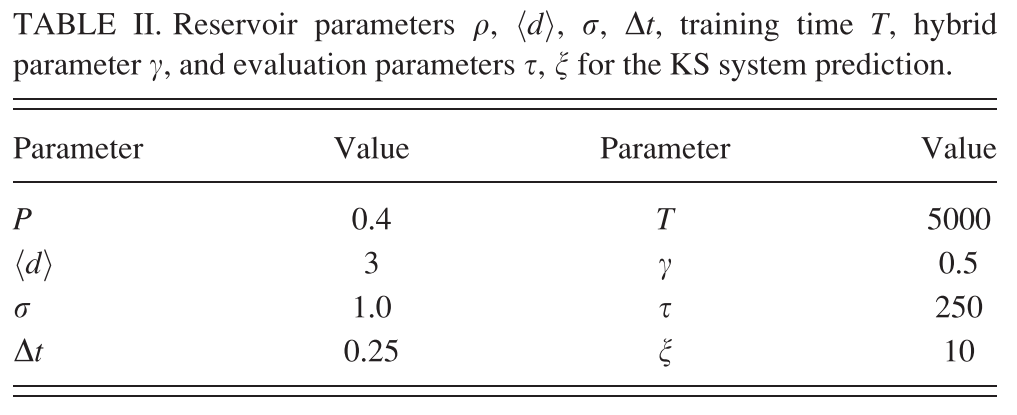

In [9]:
cash_all_results = False

# Measure parameters:
f = 0.4 # error threshhold for valid time t_v
nr_of_time_intervals = 10 # 20# 20
nr_of_reailzations = 10 # 32

#Simulation Parameters:
dt = 0.25
T = 5000 # 5000 # training time
tau = 250 # length of time intervals
xi = 10 # synchronization time
t_d = 50 # Disconnect time (not given in Paper)
t_pre = 50 # Syncing the reservoir before starting to train (not given in Paper -> Change)
t_disc = 2000 # Discard time to reach the attractor after the starting position (not given in Paper)

# KS Parameters:
Lyapunov = 0.07
L = 35
Q = 64

# RC:
network_type = "erdos_renyi_directed"
sigma = 1.0
avg_deg = 3
p = 0.4 # largest eigenvalue (spectral radius)
gamma = 0.5 # percentage of res nodes connected to raw input
beta = 1e-5# regularization parameter (not given in Paper)
w_in_sparse = True
w_in_ordered = False
act_fct_flag = "tanh_simple"
w_out_fit_flag = "linear_and_square_r_alt" # "linear_and_square_r_alt"
# w_out_fit_flag = "linear_r" # "linear_and_square_r_alt"


## 1) Simulate the timeseries:
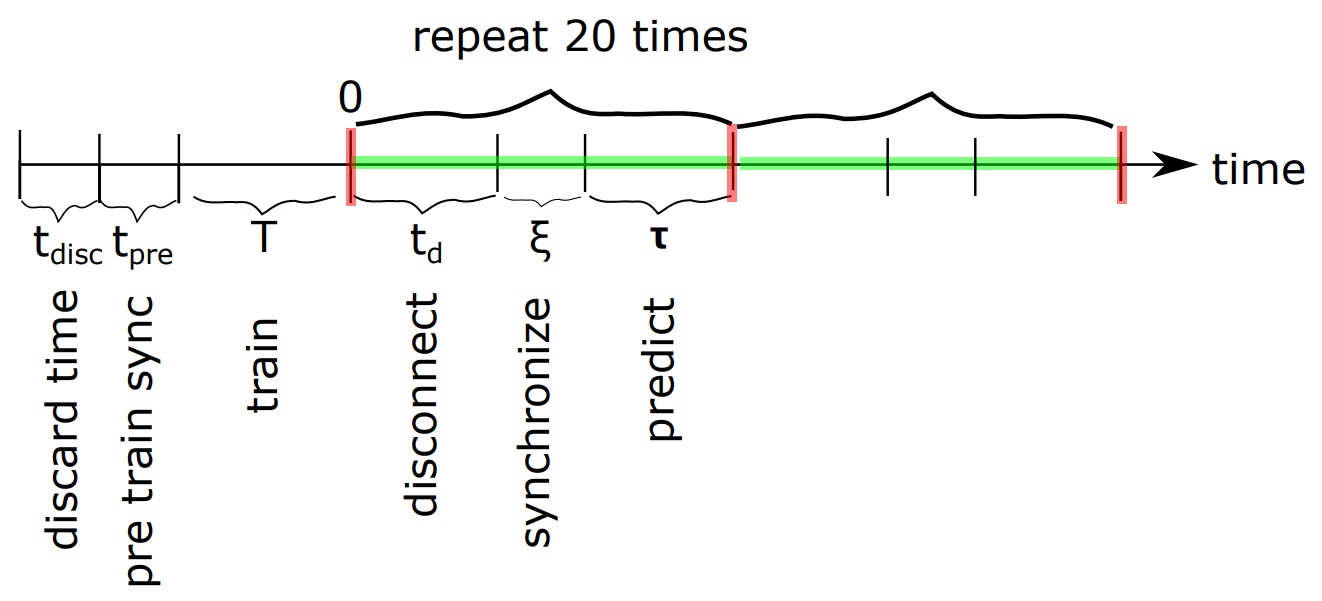

### Create KS Dataset:

In [10]:
eps = 0.0 # The original Model

# Create KS data set:
discard_steps = int(t_disc/dt)
pre_train_sync_steps = int(t_pre/dt)
train_steps = int(T/dt)
disconnect_steps = int(t_d/dt)
pre_pred_sync_steps = int(xi/dt)
predict_steps = int(tau/dt)
total_time_steps = discard_steps + pre_train_sync_steps + train_steps + (disconnect_steps + pre_pred_sync_steps + predict_steps)*nr_of_time_intervals

print("discard_steps: ", discard_steps)
print("pre_train_sync_steps: ", pre_train_sync_steps)
print("train_steps: ", train_steps)
print("disconnect_steps: ", disconnect_steps)
print("pre_pred_sync_steps: ", pre_pred_sync_steps)
print("predict_steps: ", predict_steps)
print("total_time_steps: ", total_time_steps)
print("................................")

# Uses runge kutta (not given in paper how trajectory is simulated)
sim_data = rescomp.simulate_trajectory(
    sys_flag='kuramoto_sivashinsky', dimensions=Q, system_size=L, dt=dt,
    time_steps=total_time_steps, eps = eps)

print("sim_data shape: ", sim_data.shape)

x_train = sim_data[discard_steps :pre_train_sync_steps + train_steps]
print("x_train shape: ", x_train.shape)

x_pred_list = []


start = discard_steps + pre_train_sync_steps + train_steps
n_period = disconnect_steps + pre_pred_sync_steps + predict_steps
for i in range(nr_of_time_intervals):
    x_pred = sim_data[start + i*n_period + disconnect_steps : start + (i+1)*n_period]
    x_pred_list.append(x_pred)
print("x_pred shape: ", x_pred.shape)

times_per_pred_lyap = np.arange(0, predict_steps)*dt*Lyapunov

discard_steps:  8000
pre_train_sync_steps:  200
train_steps:  20000
disconnect_steps:  200
pre_pred_sync_steps:  40
predict_steps:  1000
total_time_steps:  40600
................................
sim_data shape:  (40600, 64)
x_train shape:  (12200, 64)
x_pred shape:  (1040, 64)


Text(0.5, 0, 'Time $(t\\, \\lambda)$')

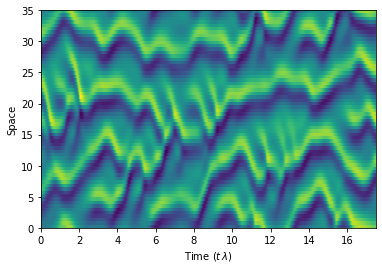

In [11]:
part = 0
to_plot = x_pred_list[part]
ax = plt.gca()
ax.imshow(to_plot.T, aspect='auto', extent= [0, predict_steps*dt*Lyapunov, 0, L])
ax.set_ylabel("Space")
ax.set_xlabel(r"Time $(t\, \lambda)$")

### Functions:

In [12]:
def variation_of_KS_model(dt, eps = 0.0):
    def model_pred(x):
        sim = rescomp.simulate_trajectory(
            sys_flag='kuramoto_sivashinsky', dimensions=Q, system_size=L, dt=dt,
            time_steps=2, starting_point = x, eps = eps) # Only simulate one time Step
        return sim[-1, :]
    return model_pred

def do_ens_experiment_rc(n_dim, model = "normal", eps = 0.0):
    results = np.zeros((nr_of_reailzations, nr_of_time_intervals, 2, predict_steps-1, Q))
    
    if model == "hybrid":
        model_pred = variation_of_KS_model(dt, eps = eps)
    
    for i in range(nr_of_reailzations):
        print(f"Realization: {i+1}/{nr_of_reailzations}" )
        
        if model == "normal":
            esn = rescomp.esn.ESNWrapper()
            
        elif model == "hybrid":
            esn = rescomp.esn.ESNHybrid()
            
        esn.create_network(n_dim = n_dim, n_rad=p, n_avg_deg=avg_deg, n_type_flag=network_type) # should be directed
        
        if model == "hybrid":
            esn.set_model(model_pred, add_model_to_input = True, add_model_to_output = True)
        
        esn.train(x_train = x_train, sync_steps = pre_train_sync_steps, reg_param=beta, w_in_scale=sigma,
                  w_in_sparse = w_in_sparse, w_in_ordered=w_in_ordered, act_fct_flag=act_fct_flag, 
                 w_out_fit_flag = w_out_fit_flag) #should have different w_out_fit_flag

        for j in range(nr_of_time_intervals):
            x_pred = x_pred_list[j]
            y_pred, y_test = esn.predict(x_pred = x_pred, sync_steps=pre_pred_sync_steps)
            results[i, j, 0, :, :] = y_test
            results[i, j, 1, :, :] = y_pred
    return results

def do_ens_experiment_model(eps = 0.0):
    results = np.zeros((nr_of_time_intervals, 2, predict_steps-1, Q))
    model_pred = variation_of_KS_model(dt, eps = eps) 
    for j in range(nr_of_time_intervals):
        x_pred = x_pred_list[j]
        x_pred = x_pred[pre_pred_sync_steps:, :]
        y_test = x_pred[1:]
        y_pred = np.zeros(x_pred.shape)
        x_0 = x_pred[0]
        x_i = x_0
        y_pred[0, :] = x_0
        for i in range(1, predict_steps):
            x_i = model_pred(x_i)
            y_pred[i, :] = x_i
        
        results[j, 0, :, :] = y_test
        results[j, 1, :, :] = y_pred[1:, :]
    return results


def Error(y_pred, y_test): #temporaray changed
    normalization = np.sqrt(np.mean(np.linalg.norm(y_test, axis=1)**2))
    return rescomp.measures.rmse_over_time(y_pred, y_test, normalization=normalization)

def Error_(y_pred, y_test):
    dif = y_pred - y_test
    top = np.linalg.norm(dif, axis = 1)
    bottom = np.sqrt(np.average(np.linalg.norm(y_test, axis = 1)**2))
    return top/bottom

def get_valid_time_index(error_array, f):
    for i, error in enumerate(error_array):
        if error > f:
            return i
    return i
        
def get_valid_times_rc(results):
    print("...getting valid times (RC)..:")
    Error_list = np.zeros((nr_of_reailzations, nr_of_time_intervals, predict_steps-1))
    valid_time_list = np.zeros((nr_of_reailzations, nr_of_time_intervals)) 
    for i in range(nr_of_reailzations):
        print(f"Valid time realization: {i+1}/{nr_of_reailzations}" )
        for j in range(nr_of_time_intervals):
            y_test, y_pred = results[i, j, 0, :, :], results[i, j, 1, :, :]
            error_array = Error(y_pred, y_test)
            valid_time_index = get_valid_time_index(error_array, f)
            Error_list[i, j, :] = error_array
            valid_time_list[i, j] = valid_time_index
    return valid_time_list

def get_valid_times_model(results):
    print("...getting valid times (Model)..:")
    Error_list = np.zeros((nr_of_time_intervals, predict_steps-1))
    valid_time_list = np.zeros((nr_of_time_intervals)) 

    for j in range(nr_of_time_intervals):
        y_test, y_pred = results[j, 0, :, :], results[j, 1, :, :]
        error_array = Error(y_pred, y_test)
        valid_time_index = get_valid_time_index(error_array, f)
        Error_list[j, :] = error_array
        valid_time_list[j] = valid_time_index
    return valid_time_list

## Experiment 1: Valid time vs. Reservoir Dimension

In [13]:
# Experiment parameters:
n_dims = np.linspace(50, 8000, 10, endpoint=True, dtype = int)
# n_dims = np.linspace(6000, 8000, 3, endpoint=True, dtype = int)

# n_dims = np.array([500])
# n_dims = n_dims[-1:] #temp
eps = 1
print("reservoir sizes: ", n_dims)

reservoir sizes:  [  50  933 1816 2700 3583 4466 5350 6233 7116 8000]


In [ ]:
# SKIP CELL IF YOU WANT TO LOAD DATA:

# normal and Hybrid RC and model simulation:
if cash_all_results:
    results_normal_array = np.zeros((n_dims.size, nr_of_reailzations, nr_of_time_intervals, predict_steps-1, Q))
    results_hybrid_array = np.zeros((n_dims.size, nr_of_reailzations, nr_of_time_intervals, predict_steps-1, Q))
    results_model_array = np.zeros((n_dims.size, nr_of_time_intervals, predict_steps-1, Q))


valid_times_results_normal = np.zeros((n_dims.size, nr_of_reailzations, nr_of_time_intervals))
valid_times_results_hybrid = np.zeros((n_dims.size, nr_of_reailzations, nr_of_time_intervals))
valid_times_results_model = np.zeros((n_dims.size, nr_of_time_intervals))

print("=== Simulation Model based prediction ===")
results_model = do_ens_experiment_model(eps = eps)
valid_times_model = get_valid_times_model(results_model)

print("=== Starting RC calculations ===")

for i_n, n_dim in enumerate(n_dims):
    valid_times_results_model[i_n, :] = valid_times_model
    
    print(f" ---- Starting experiment for n_dim = {n_dim} ----")
    print("-.-.- Normal RC -.-.-")
    results_normal = do_ens_experiment_rc(n_dim, model = "normal")
    valid_times_normal = get_valid_times_rc(results_normal)
    
    print("-.-.- Hybrid RC -.-.-")
    results_hybrid = do_ens_experiment_rc(n_dim, model = "hybrid", eps = eps)
    valid_times_hybrid = get_valid_times_rc(results_hybrid)
    
    if cash_all_results:
        results_model_array[i_n, :, :, :] = results_model[:, 1, :, :]
        results_hybrid_array[i_n, :, :, :, :] = results_hybrid[:, :, 1, :, :]
        results_normal_array[i_n, :, :, :, :] = results_normal[:, :, 1, :, :]
    
    valid_times_results_normal[i_n, :, :] = valid_times_normal
    valid_times_results_hybrid[i_n, :, :] = valid_times_hybrid

=== Simulation Model based prediction ===
...getting valid times (Model)..:
=== Starting RC calculations ===
 ---- Starting experiment for n_dim = 50 ----
-.-.- Normal RC -.-.-
Realization: 1/10
Realization: 2/10
Realization: 3/10
Realization: 4/10
Realization: 5/10
Realization: 6/10
Realization: 7/10
Realization: 8/10
Realization: 9/10
Realization: 10/10
...getting valid times (RC)..:
Valid time realization: 1/10
Valid time realization: 2/10
Valid time realization: 3/10
Valid time realization: 4/10
Valid time realization: 5/10
Valid time realization: 6/10
Valid time realization: 7/10
Valid time realization: 8/10
Valid time realization: 9/10
Valid time realization: 10/10
-.-.- Hybrid RC -.-.-
Realization: 1/10
Realization: 2/10
Realization: 3/10
Realization: 4/10
Realization: 5/10
Realization: 6/10
Realization: 7/10
Realization: 8/10
Realization: 9/10
Realization: 10/10
...getting valid times (RC)..:
Valid time realization: 1/10
Valid time realization: 2/10
Valid time realization: 3/10

Valid time realization: 6/10
Valid time realization: 7/10
Valid time realization: 8/10
Valid time realization: 9/10
Valid time realization: 10/10
-.-.- Hybrid RC -.-.-
Realization: 1/10
Realization: 2/10
Realization: 3/10
Realization: 4/10
Realization: 5/10
Realization: 6/10
Realization: 7/10
Realization: 8/10
Realization: 9/10
Realization: 10/10
...getting valid times (RC)..:
Valid time realization: 1/10
Valid time realization: 2/10
Valid time realization: 3/10
Valid time realization: 4/10
Valid time realization: 5/10
Valid time realization: 6/10
Valid time realization: 7/10
Valid time realization: 8/10
Valid time realization: 9/10
Valid time realization: 10/10
 ---- Starting experiment for n_dim = 7116 ----
-.-.- Normal RC -.-.-
Realization: 1/10
Realization: 2/10
Realization: 3/10
Realization: 4/10
Realization: 5/10
Realization: 6/10
Realization: 7/10
Realization: 8/10
Realization: 9/10
Realization: 10/10
...getting valid times (RC)..:
Valid time realization: 1/10
Valid time realiza

In [11]:
# SKIP IF YOU WANT TO LOAD DATA:
# SAVE data:
pre_path = r"C:\Users\Dennis\Documents\FILES&INFO\WISSEN\STUDIUM\Master LMU\Masterthesis\Simulations/"
if cash_all_results:
    np.save(pre_path + r"results_model_array" , results_model_array)
    np.save(pre_path + r"results_hybrid_array" , results_hybrid_array)
    np.save(pre_path + r"results_normal_array" , results_normal_array)
    
np.save(pre_path + r"valid_times_results_normal" , valid_times_results_normal)
np.save(pre_path + r"valid_times_results_hybrid" , valid_times_results_hybrid)
np.save(pre_path + r"valid_times_results_model" , valid_times_results_model)

In [ ]:
# LOAD data:
pre_path = r"C:\Users\Dennis\Documents\FILES&INFO\WISSEN\STUDIUM\Master LMU\Masterthesis\Simulations/"
if cash_all_results:
    results_model_array = np.load(pre_path + r"results_model_array.npy")
    results_hybrid_array = np.load(pre_path + r"results_hybrid_array.npy")
    results_normal_array = np.load(pre_path + r"results_normal_array.npy")
    
valid_times_results_normal = np.load(pre_path + r"valid_times_results_normal.npy")
valid_times_results_hybrid = np.load(pre_path + r"valid_times_results_hybrid.npy")
valid_times_results_model = np.load(pre_path + r"valid_times_results_model.npy")

..showing single trajectories: ..
realization:  0
part:  1
Res dim:  8000
SHOW DIFFERENCES to Sim:  True


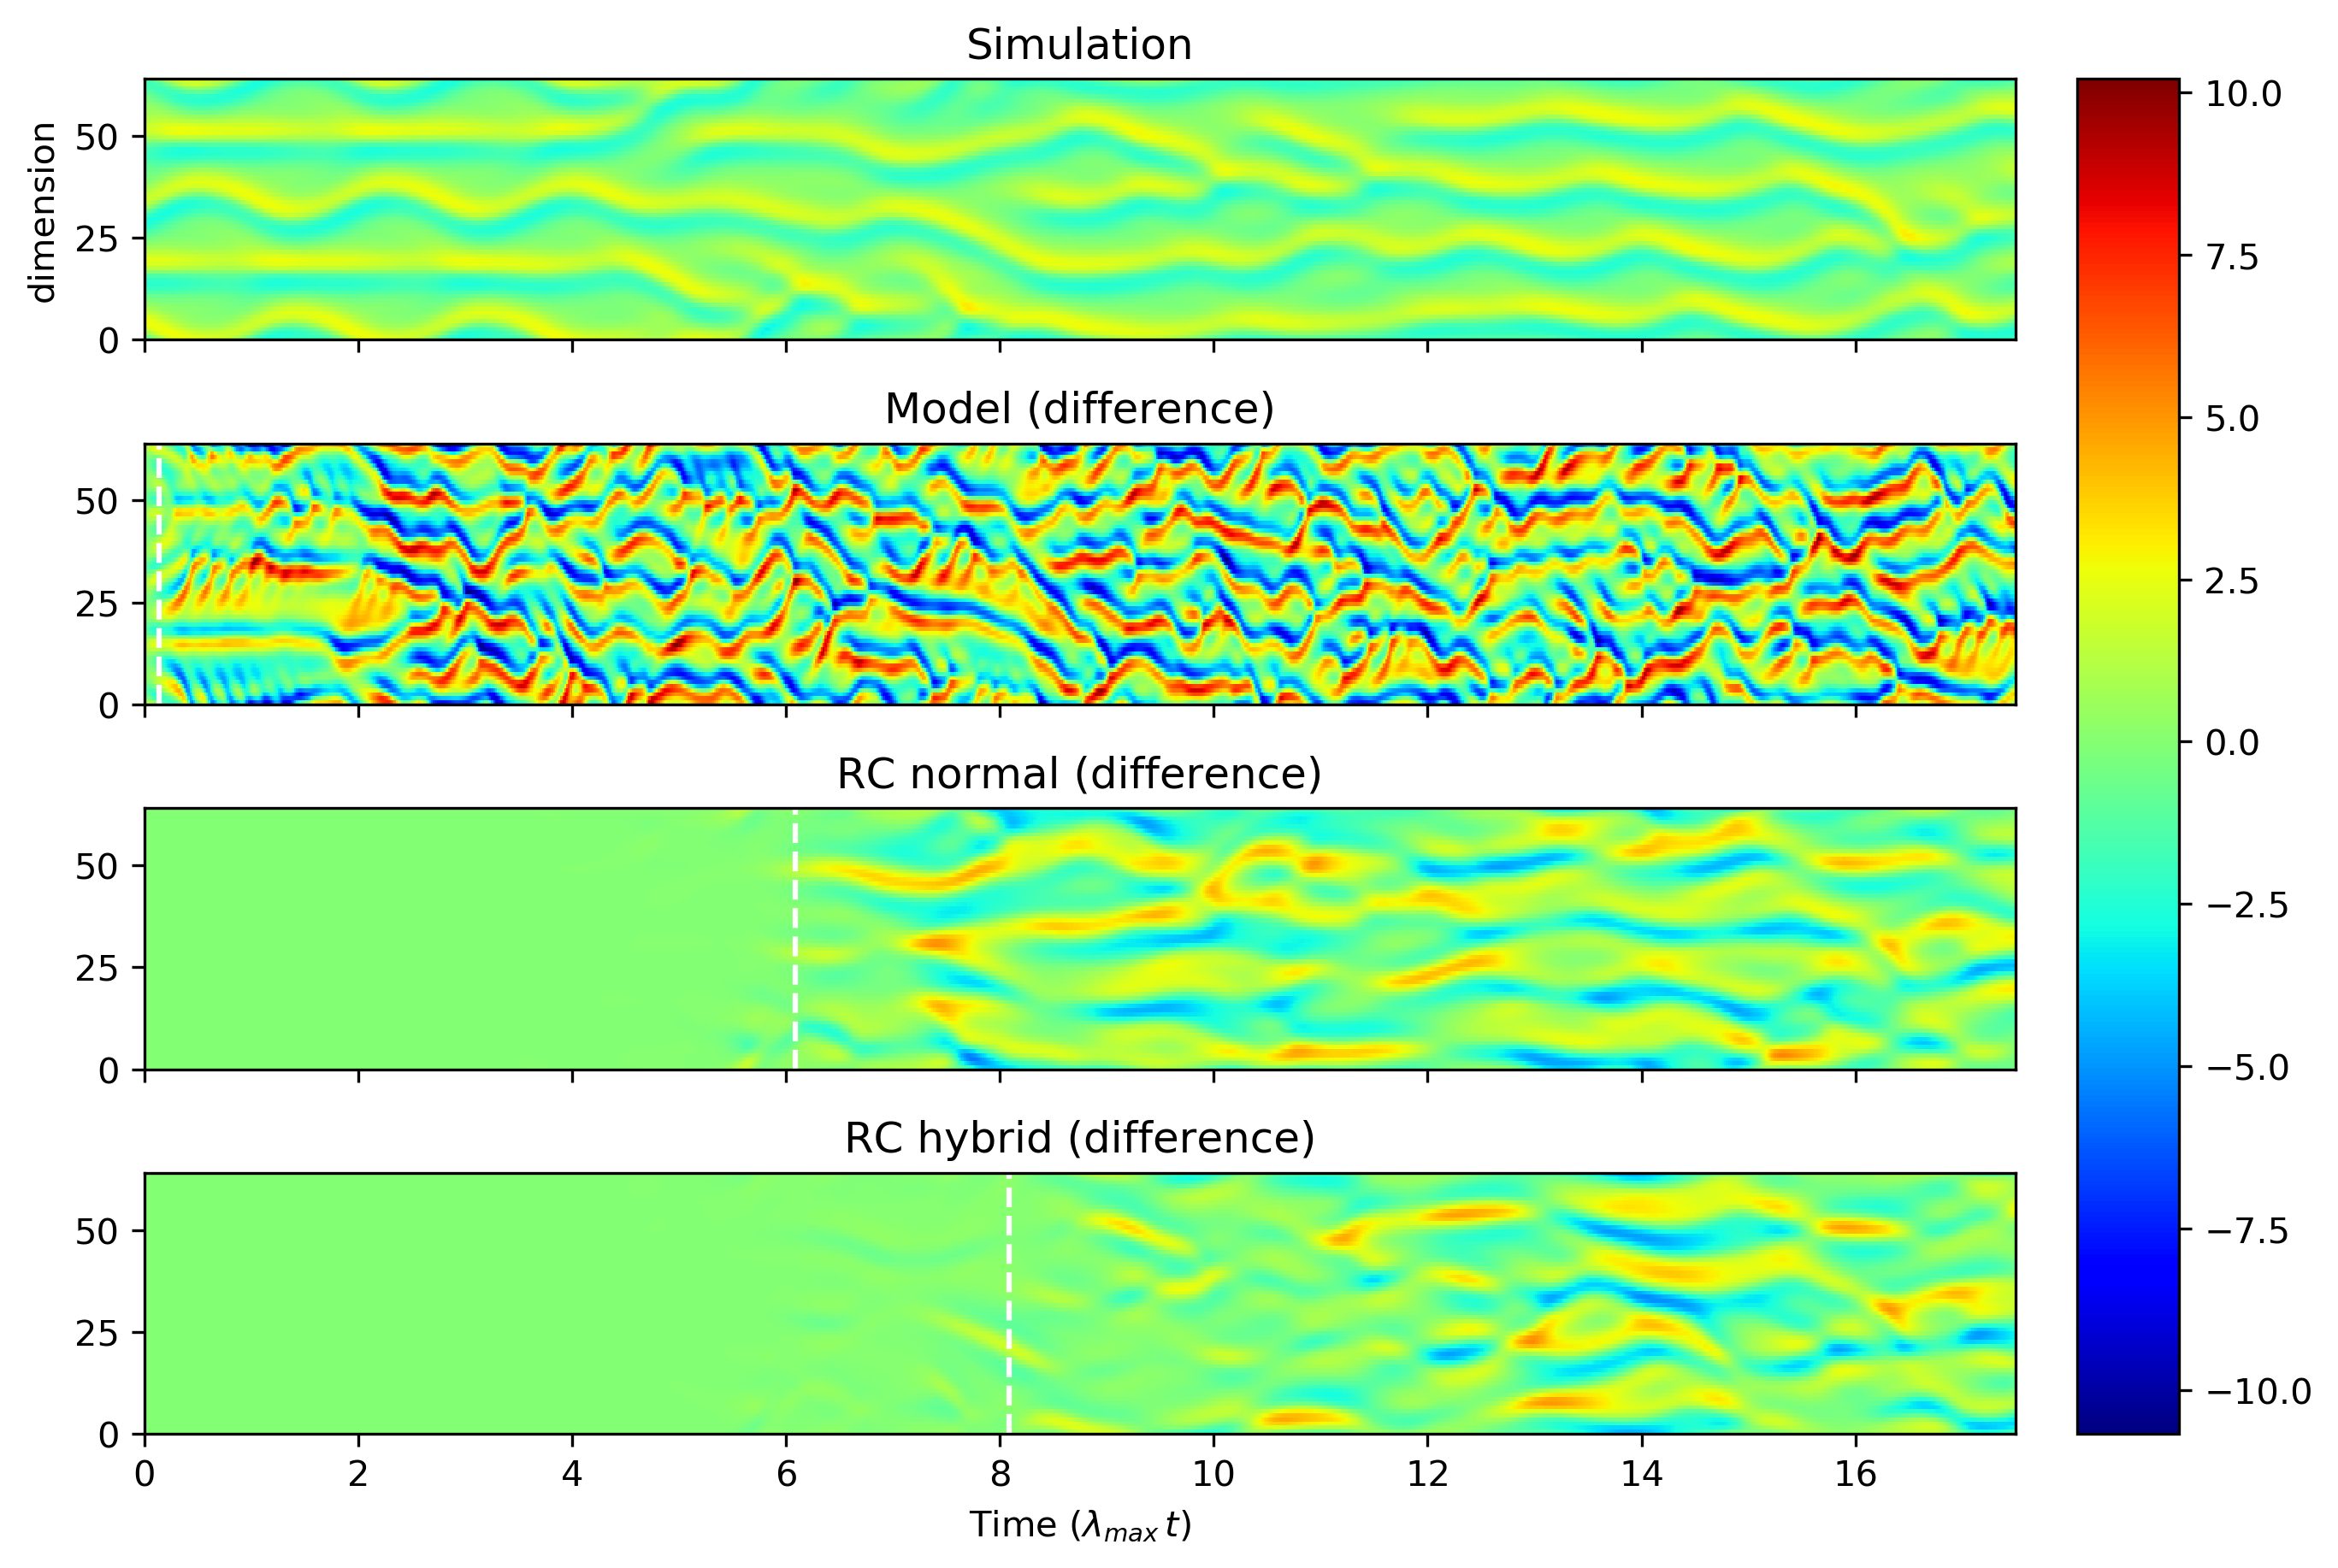

In [16]:
# Show single trajectories:
############################
show_difference = True
show_valid_time = True
show_real_time = True
use_joint_colors = True

timeend = 10000
part = 1
realization = 0
n_i = 0 # only effect if cash_all_results = True

cmap = "jet"
###########################

if show_real_time:
    if timeend > predict_steps:
        timeend = predict_steps
    
    x_label = r"Time $(\lambda_{max}\, t)$"
    extent= [0, timeend*dt*Lyapunov, 0, Q]
else:
    x_label = "time steps"
    extent = None
to_add = ""

print("..showing single trajectories: ..")
print("realization: ", realization)
print("part: ", part)
if not cash_all_results:
    res_dim = n_dims[-1]
elif cash_all_results:
    res_dim = n_dims[n_i]
print("Res dim: ", res_dim)
print("SHOW DIFFERENCES to Sim: ", show_difference)

y_pred_sim =  x_pred_list[part][pre_pred_sync_steps+1:timeend+pre_pred_sync_steps+1, :]

if cash_all_results:
    y_pred_norm = results_normal_array[n_i, realization, part, :timeend, :]
    y_pred_hybrid = results_hybrid_array[n_i, realization, part, :timeend, :]
    y_pred_model = results_model_array[n_i, part, :timeend, :]
else:
    _, y_pred_norm = (results_normal[realization, part, i, :timeend, :] for i in (0,1))
    _, y_pred_hybrid = (results_hybrid[realization, part, i, :timeend, :] for i in (0,1))
    _, y_pred_model = (results_model[part, i, :timeend, :] for i in (0,1))

if show_valid_time:
    factor = 1
    if show_real_time:
        factor = Lyapunov*dt
    
    valid_time_index_norm = get_valid_time_index(Error(y_pred_sim, y_pred_norm), f)*factor
    valid_time_index_hybrid = get_valid_time_index(Error(y_pred_sim, y_pred_hybrid), f)*factor
    valid_time_index_model = get_valid_time_index(Error(y_pred_sim, y_pred_model), f)*factor

if show_difference:
    to_add = " (difference)"
    y_pred_norm = y_pred_sim - y_pred_norm
    y_pred_hybrid = y_pred_sim - y_pred_hybrid
    y_pred_model = y_pred_sim - y_pred_model

fig, axs = plt.subplots(4, 1, sharex="all", figsize=(9, 6),
                            constrained_layout=True, dpi=300)

if use_joint_colors:
    vmin = np.min(np.hstack((y_pred_sim, y_pred_norm, y_pred_hybrid, y_pred_model)))
    vmax = np.max(np.hstack((y_pred_sim, y_pred_norm, y_pred_hybrid, y_pred_model)))
else: 
    vmin, vmax = None, None
    
ax = axs[0]
im = ax.imshow(y_pred_sim.T, aspect='auto', vmin=vmin, vmax=vmax, extent = extent, cmap = cmap)
ax.set_title("Simulation")

ax = axs[2]
ax.imshow(y_pred_norm.T, aspect='auto', vmin=vmin, vmax=vmax, extent = extent, cmap = cmap)
ax.axvline(valid_time_index_norm, color="w", linestyle="--")
ax.set_title("RC normal"+ to_add)

ax = axs[3]
ax.imshow(y_pred_hybrid.T, aspect='auto', vmin=vmin, vmax=vmax, extent = extent, cmap = cmap)
ax.axvline(valid_time_index_hybrid, color="w", linestyle="--")
ax.set_title("RC hybrid"+ to_add)

ax = axs[1]
ax.imshow(y_pred_model.T, aspect='auto', vmin=vmin, vmax=vmax, extent = extent, cmap = cmap)
ax.axvline(valid_time_index_model, color="w", linestyle="--")
ax.set_title("Model"+ to_add)

axs[0].set_ylabel("dimension")
axs[-1].set_xlabel(x_label)

if use_joint_colors:
    fig.colorbar(im, ax=axs)

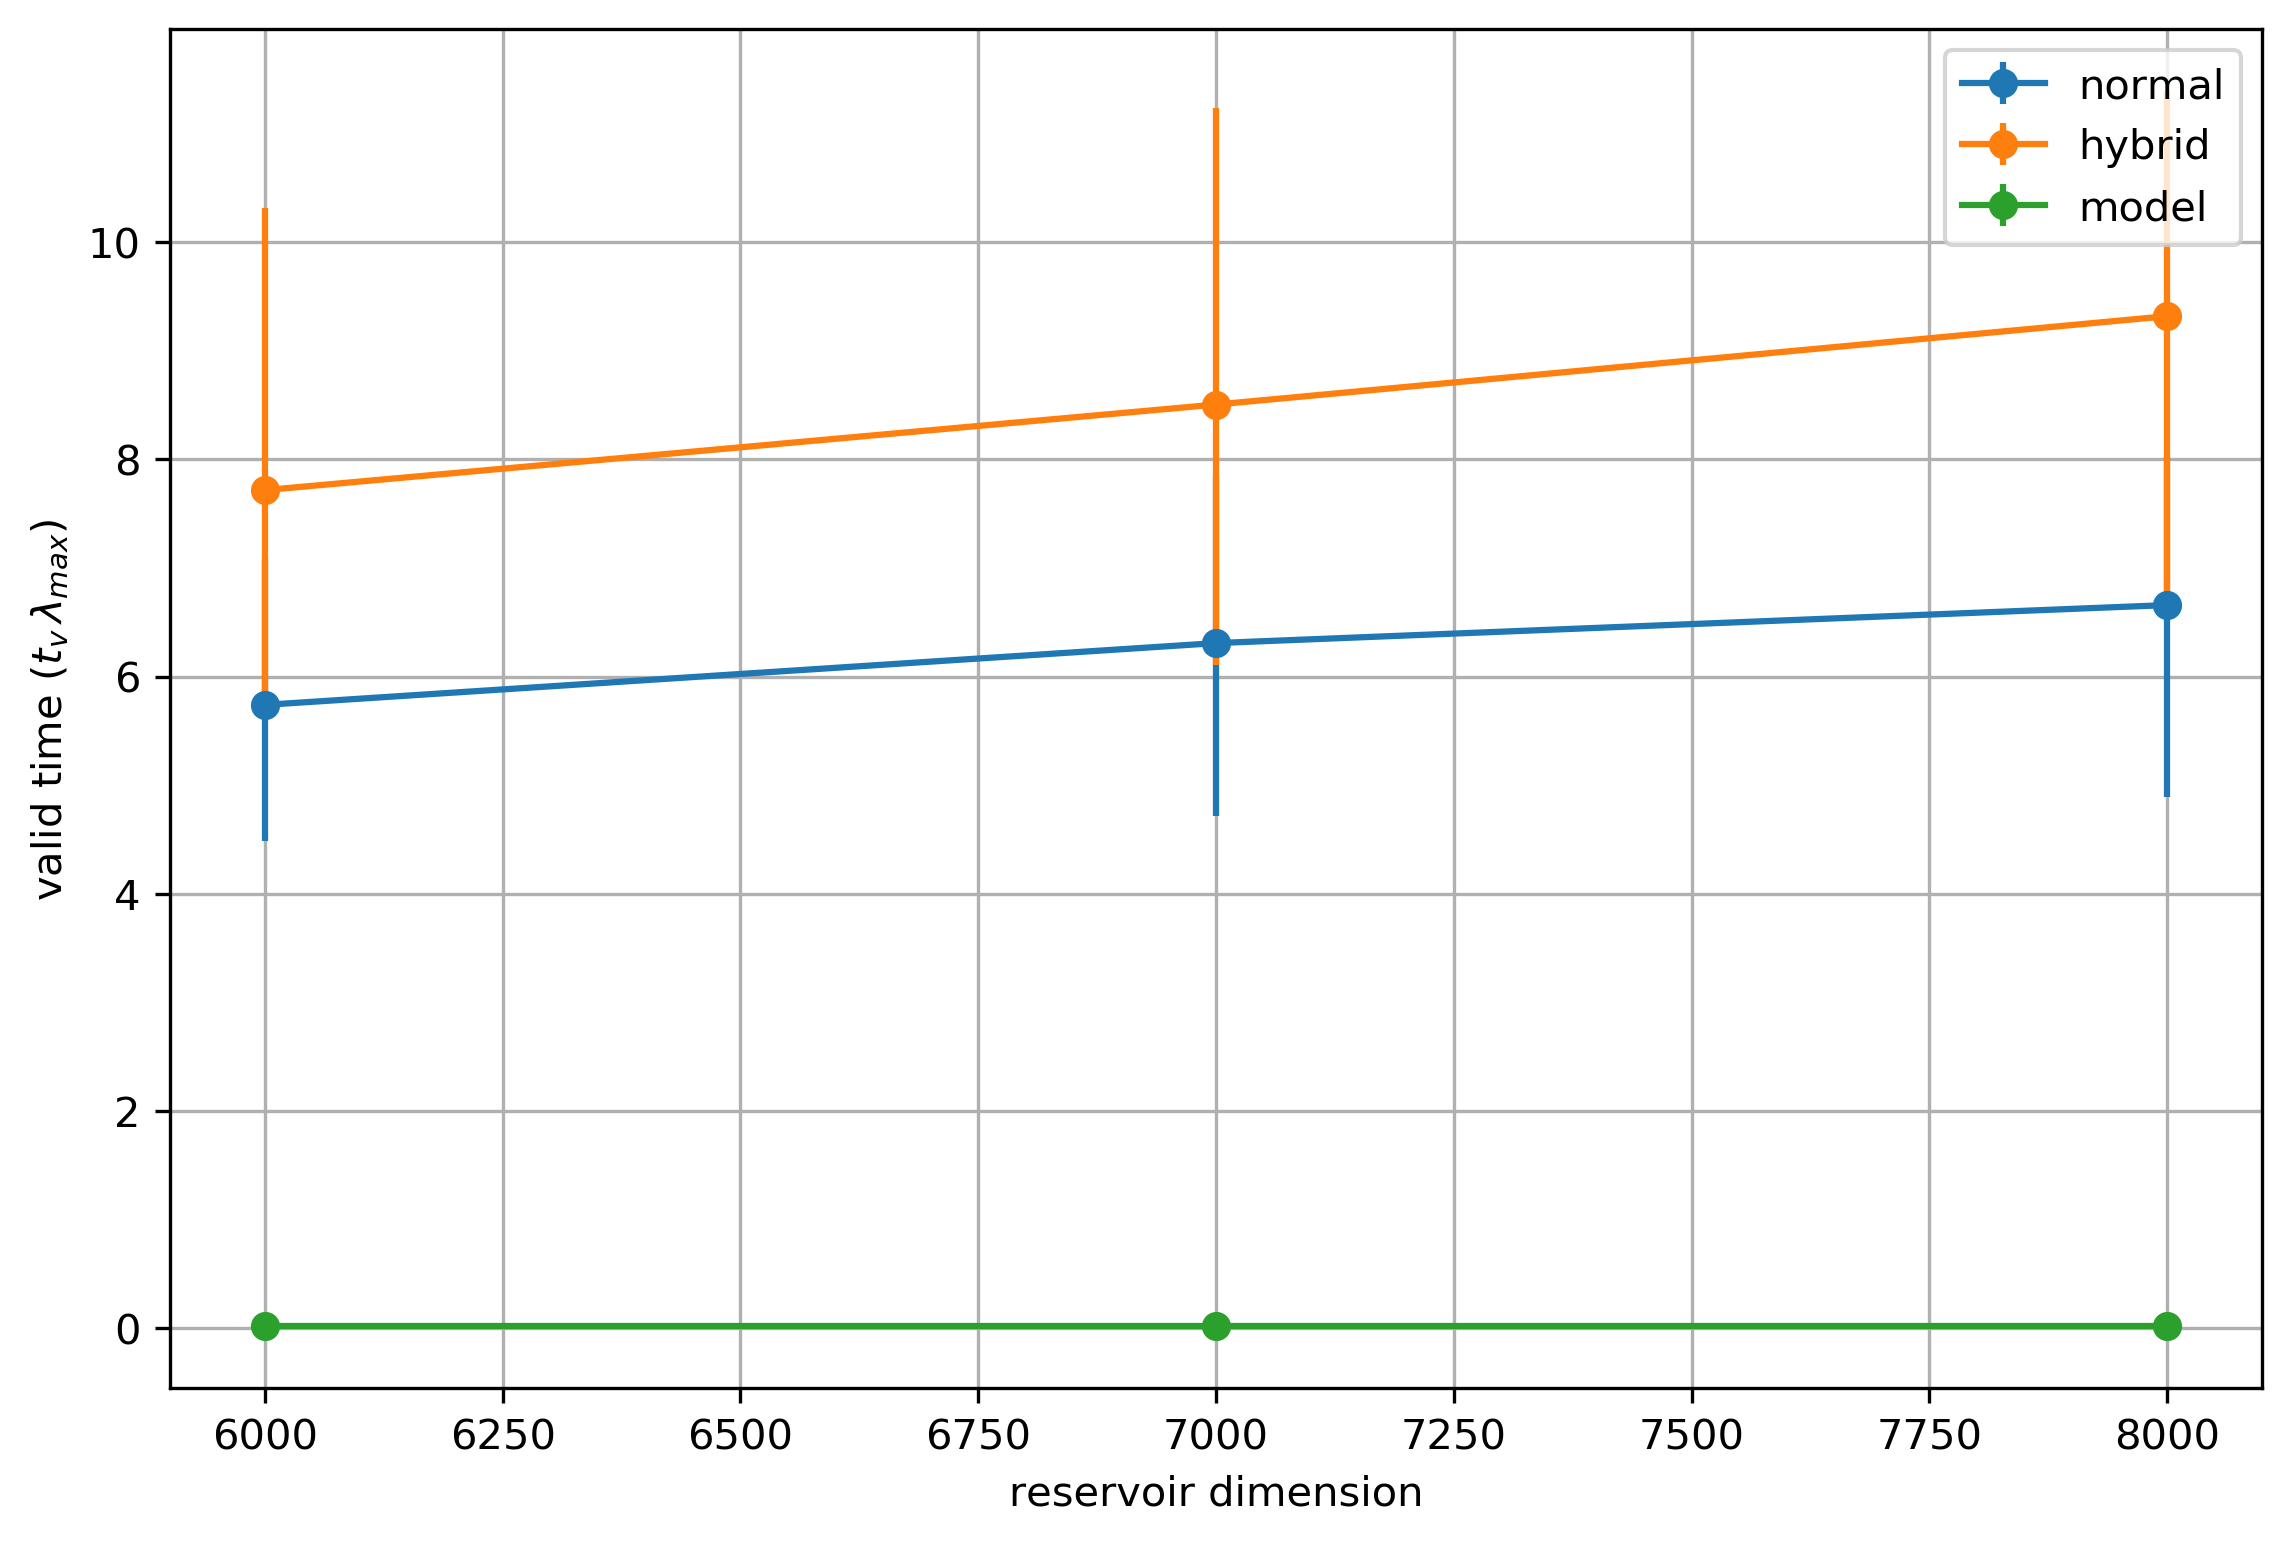

In [17]:
valid_times_dict = {}
valid_times_dict["normal"] = valid_times_results_normal
valid_times_dict["hybrid"] = valid_times_results_hybrid
valid_times_dict["model"] = valid_times_results_model

fig = plt.figure(figsize=(9, 6), dpi=300)
ax = fig.add_subplot(1, 1, 1)

scale = dt*Lyapunov

for key, val in valid_times_dict.items():
    if len(val.shape) == 3:
        axis = (-1, -2)
    elif len(val.shape) == 2:
        axis = -1
    
    median_list = np.median(val, axis = axis)*scale
    fist_quartile_list = np.quantile(val, 0.25, axis= axis)*scale
    third_quartile_list = np.quantile(val, 0.75, axis= axis)*scale
    ax.errorbar(n_dims, median_list, yerr=[median_list - fist_quartile_list, third_quartile_list - median_list], fmt='-o', label = key)

ax.set_xlabel("reservoir dimension")
ax.set_ylabel("valid time $(t_v\, \lambda_{max})$")
# ax.errorbar(n_dims, median_array_model, yerr=[lower_error_model, upper_error_model], fmt='-o', label = "model")    
plt.grid()
plt.legend()

## Experiment 2: Valid Time vs. Epsilon:

In [ ]:
# Experiment parameters:
n_dim = 50
eps_list = np.linspace(0.004, 0.1, 25)
eps_list = eps_list[-2:]
print("epsilon sweep: ", eps_list)

In [ ]:
# SKIP CELL IF YOU WANT TO LOAD DATA:

# normal and Hybrid RC and model simulation:
if cash_all_results:
    results_normal_array_eps = np.zeros((eps_list.size, nr_of_reailzations, nr_of_time_intervals, predict_steps-1, Q))
    results_hybrid_array_eps = np.zeros((eps_list.size, nr_of_reailzations, nr_of_time_intervals, predict_steps-1, Q))
    results_model_array_eps = np.zeros((eps_list.size, nr_of_time_intervals, predict_steps-1, Q))


valid_times_results_normal_eps = np.zeros((eps_list.size, nr_of_reailzations, nr_of_time_intervals))
valid_times_results_hybrid_eps = np.zeros((eps_list.size, nr_of_reailzations, nr_of_time_intervals))
valid_times_results_model_eps = np.zeros((eps_list.size, nr_of_time_intervals))


print("=== Starting calculations ===")

print("=== RC calculation - normal ===")
# Normal RC:
results_normal = do_ens_experiment_rc(n_dim, model = "normal")
valid_times_normal = get_valid_times_rc(results_normal)

for i_e, eps in enumerate(eps_list):
    valid_times_results_normal_eps[i_e, :, :] = valid_times_normal
    
    print(f" ---- Starting experiment for eps = {eps} ----")

    # Model based:
    print("-.-.- Model Prediction -.-.-")
    results_model = do_ens_experiment_model(eps = eps)
    valid_times_model = get_valid_times_model(results_model)
    
    # Hybrid RC: 
    print("-.-.- Hybrid RC -.-.-")
    results_hybrid = do_ens_experiment_rc(n_dim, model = "hybrid", eps = eps)
    valid_times_hybrid = get_valid_times_rc(results_hybrid)
    
    if cash_all_results:
        results_model_array_eps[i_e, :, :, :] = results_model[:, 1, :, :]
        results_hybrid_array_eps[i_e, :, :, :, :] = results_hybrid[:, :, 1, :, :]
        results_normal_array_eps[i_e, :, :, :, :] = results_normal[:, :, 1, :, :]
    
    valid_times_results_model_eps[i_e, :] = valid_times_model
    valid_times_results_hybrid_eps[i_e, :, :] = valid_times_hybrid

In [ ]:
# SKIP IF YOU WANT TO LOAD DATA:
# SAVE data:
pre_path = r"C:\Users\Dennis\Documents\FILES&INFO\WISSEN\STUDIUM\Master LMU\Masterthesis\Simulations/"
if cash_all_results:
    np.save(pre_path + r"results_model_array_eps" , results_model_array_eps)
    np.save(pre_path + r"results_hybrid_array_eps" , results_hybrid_array_eps)
    np.save(pre_path + r"results_normal_array_eps" , results_normal_array_eps)
    
np.save(pre_path + r"valid_times_results_normal_eps" , valid_times_results_normal_eps)
np.save(pre_path + r"valid_times_results_hybrid_eps" , valid_times_results_hybrid_eps)
np.save(pre_path + r"valid_times_results_model_eps" , valid_times_results_model_eps)

In [ ]:
# LOAD data:
pre_path = r"C:\Users\Dennis\Documents\FILES&INFO\WISSEN\STUDIUM\Master LMU\Masterthesis\Simulations/"
if cash_all_results:
    results_model_array_eps = np.load(pre_path + r"results_model_array_eps.npy")
    results_hybrid_array_eps = np.load(pre_path + r"results_hybrid_array_eps.npy")
    results_normal_array_eps = np.load(pre_path + r"results_normal_array_eps.npy")
    
valid_times_results_normal_eps = np.load(pre_path + r"valid_times_results_normal_eps.npy")
valid_times_results_hybrid_eps = np.load(pre_path + r"valid_times_results_hybrid_eps.npy")
valid_times_results_model_eps = np.load(pre_path + r"valid_times_results_model_eps.npy")

In [ ]:
# Show single trajectories:
############################
show_difference = False
show_valid_time = True
show_real_time = True
use_joint_colors = True
timeend = 10000
part = 2
realization = 0
e_i = 0 # only effect if cash_all_results = True
###########################

if show_real_time:
    if timeend > predict_steps:
        timeend = predict_steps
    
    x_label = r"Time $(\lambda_{max}\, t)$"
    extent= [0, timeend*dt*Lyapunov, 0, Q]
else:
    x_label = "time steps"
    extent = None
to_add = ""

print("..showing single trajectories: ..")
print("realization: ", realization)
print("part: ", part)
if not cash_all_results:
    current_eps = eps_list[-1]
elif cash_all_results:
    current_eps = eps_list[e_i]
print("epsilon: ", current_eps)
print("SHOW DIFFERENCES to Sim: ", show_difference)

y_pred_sim =  x_pred_list[part][pre_pred_sync_steps+1:timeend+pre_pred_sync_steps+1, :]

if cash_all_results:
    y_pred_norm = results_normal_array_eps[e_i, realization, part, :timeend, :]
    y_pred_hybrid = results_hybrid_array_eps[e_i, realization, part, :timeend, :]
    y_pred_model = results_model_array_eps[e_i, part, :timeend, :]
else:
    _, y_pred_norm = (results_normal_eps[realization, part, i, :timeend, :] for i in (0,1))
    _, y_pred_hybrid = (results_hybrid_eps[realization, part, i, :timeend, :] for i in (0,1))
    _, y_pred_model = (results_model_eps[part, i, :timeend, :] for i in (0,1))

if show_valid_time:
    factor = 1
    if show_real_time:
        factor = Lyapunov*dt
    
    valid_time_index_norm = get_valid_time_index(Error(y_pred_sim, y_pred_norm), f)*factor
    valid_time_index_hybrid = get_valid_time_index(Error(y_pred_sim, y_pred_hybrid), f)*factor
    valid_time_index_model = get_valid_time_index(Error(y_pred_sim, y_pred_model), f)*factor

if show_difference:
    to_add = " (difference)"
    y_pred_norm = y_pred_sim - y_pred_norm
    y_pred_hybrid = y_pred_sim - y_pred_hybrid
    y_pred_model = y_pred_sim - y_pred_model

fig, axs = plt.subplots(4, 1, sharex="all", figsize=(9, 6),
                            constrained_layout=True, dpi=300)

if use_joint_colors:
    vmin = np.min(np.hstack((y_pred_sim, y_pred_norm, y_pred_hybrid, y_pred_model)))
    vmax = np.max(np.hstack((y_pred_sim, y_pred_norm, y_pred_hybrid, y_pred_model)))
else: 
    vmin, vmax = None, None

ax = axs[0]
ax.imshow(y_pred_sim.T, aspect='auto', vmin=vmin, vmax=vmax, extent = extent)
ax.set_title("Simulation")

ax = axs[1]
ax.imshow(y_pred_norm.T, aspect='auto', vmin=vmin, vmax=vmax, extent = extent)
ax.axvline(valid_time_index_norm, color="w", linestyle="--")
ax.set_title("RC normal"+ to_add)

ax = axs[2]
ax.imshow(y_pred_hybrid.T, aspect='auto', vmin=vmin, vmax=vmax, extent = extent)
ax.axvline(valid_time_index_hybrid, color="w", linestyle="--")
ax.set_title("RC hybrid"+ to_add)

ax = axs[3]
ax.imshow(y_pred_model.T, aspect='auto', vmin=vmin, vmax=vmax, extent = extent)
ax.axvline(valid_time_index_model, color="w", linestyle="--")
ax.set_title("Model"+ to_add)

axs[0].set_ylabel("dimension")
axs[-1].set_xlabel(x_label)

if use_joint_colors:
    fig.colorbar(im, ax=axs)

In [ ]:
valid_times_dict = {}
valid_times_dict["normal"] = valid_times_results_normal_eps
valid_times_dict["hybrid"] = valid_times_results_hybrid_eps
valid_times_dict["model"] = valid_times_results_model_eps

fig = plt.figure(figsize=(9, 6), dpi=300)
ax = fig.add_subplot(1, 1, 1)

scale = dt*Lyapunov

for key, val in valid_times_dict.items():
    if len(val.shape) == 3:
        axis = (-1, -2)
    elif len(val.shape) == 2:
        axis = -1
    
    median_list = np.median(val, axis = axis)*scale
    fist_quartile_list = np.quantile(val, 0.25, axis= axis)*scale
    third_quartile_list = np.quantile(val, 0.75, axis= axis)*scale
    ax.errorbar(eps_list, median_list, yerr=[median_list - fist_quartile_list, third_quartile_list - median_list], fmt='-o', label = key)

ax.set_xlabel("epsilon")
ax.set_ylabel("valid time $(t_v\, \lambda_{max})$")
# ax.errorbar(n_dims, median_array_model, yerr=[lower_error_model, upper_error_model], fmt='-o', label = "model")    
plt.grid()
plt.legend()

# SAVE DATA:

In [ ]:
# Save Data:
np.save(r"C:\Users\Dennis\Documents\FILES&INFO\WISSEN\STUDIUM\Master LMU\Masterthesis\Simulations\valid_times_results_hybrid" , valid_times_results_hybrid)

# LOAD DATA:

In [ ]:
valid_times_results_hybrid = np.load(r"C:\Users\Dennis\Documents\FILES&INFO\WISSEN\STUDIUM\Master LMU\Masterthesis\Simulations\valid_times_results_hybrid.npy")

valid_times_results_normal = np.load(r"C:\Users\Dennis\Documents\FILES&INFO\WISSEN\STUDIUM\Master LMU\Masterthesis\Simulations\valid_times_results_normal.npy")

# TEST:

In [ ]:
# normal and Hybrid RC:


valid_times_results_eps_model = np.zeros((eps_list.size, nr_of_reailzations, nr_of_time_intervals))
valid_times_results_eps_hybrid = np.zeros((eps_list.size, nr_of_reailzations, nr_of_time_intervals))

print("=== Starting RC calculations ===")

for i_e, eps in enumerate(eps_list):
    print(f" ---- Starting experiment for eps = {eps} ----")
    print("-.-.- Model Prediction -.-.-")
    
    
    print("-.-.- Hybrid RC -.-.-")
    results_hybrid = do_ens_experiment(n_dim=50, model = "hybrid", eps = eps)
    valid_times_hybrid = get_valid_times(results_hybrid)
    
    valid_times_results_eps_model[i_e, :, :] = valid_times_model
    valid_times_results_eps_hybrid[i_e, :, :] = valid_times_hybrid

In [ ]:
# Only Modelbased:

model_pred = variation_of_lorenz_model(dt, eps2 = eps)

y_pred_results_model = np.zeros((nr_of_time_intervals, predict_steps, 3))
for i, x_pred in enumerate(x_pred_list):
    x_pred = x_pred[pre_pred_sync_steps:, :]
    y_pred = np.zeros(x_pred.shape)
    x_0 = x_pred[0]
    x_i = x_0
    y_pred_results_model[i, 0, :] = x_i
    for j in range(1, predict_steps):
        x_i = model_pred(x_i)
        y_pred_results_model[i, j, :] = x_i

# plt.plot(y_pred_results_model[0, :, 0])
error_results_model = np.zeros((nr_of_time_intervals, predict_steps-1))
valid_times_result_model = np.zeros(nr_of_time_intervals)

for i in range(nr_of_time_intervals):
    y_pred, y_test = y_pred_results_model[i, :, :], x_pred_list[i][pre_pred_sync_steps+1:]
    error_array = Error(y_pred, y_test)
    error_results_model[i, :] = error_array
    valid_times_result_model[i] = get_valid_time_index(error_array, f)

print(valid_times_result_model.shape)

first_quantile_model = np.quantile(valid_times_result_model, 0.25)
median_model = np.median(valid_times_result_model)
third_quantile_model = np.quantile(valid_times_result_model, 0.75)

median_array_model = np.array([median_model, ]*n_dims.size)
lower_error_model = median_array_model - first_quantile_model
upper_error_model = third_quantile_model - median_array_model

In [ ]:
plt.figure(figsize = (9, 6))
timeend = 100
part = 0
xyz = 0

y_pred = y_pred_results_model[part, :timeend, xyz]
x_pred = x_pred_list[part][pre_pred_sync_steps:pre_pred_sync_steps+timeend, xyz]
plt.plot(y_pred)
plt.plot(x_pred)

In [ ]:
r = np.ones((10, 3))*2
print(r.shape)
r[1::2, :] = r[1::2, :]**2
print(r.shape)

# OLD

In [ ]:
# Show single trajectories:

fig = plt.figure(figsize=(9, 6), dpi=300)
timeend = 150
part = 1
realization = 0
xyz = 0

e_i = 0
print("epsilon: ", eps_list[e_i])
if cash_all_results:
    y_pred = results_normal_array_eps[e_i, realization, part, :timeend, xyz]
    plt.plot(y_pred, label = "normal")
    y_pred = results_hybrid_array_eps[e_i, realization, part, :timeend, xyz] 
    plt.plot(y_pred, label = "hybrid")
    y_pred = results_model_array_eps[e_i, part, :timeend, xyz]
    plt.plot(y_pred, label = "model")
    plt.plot(x_pred_list[part][pre_pred_sync_steps+1:timeend+pre_pred_sync_steps+1, xyz], label = "real")
else:
    y_test, y_pred = (results_normal[realization, part, i, :timeend, xyz] for i in (0,1))
    plt.plot(y_pred, label = "normal")
    y_test, y_pred = (results_hybrid[realization, part, i, :timeend, xyz] for i in (0,1))
    plt.plot(y_pred, label = "hybrid")
    y_test, y_pred = (results_model[part, i, :timeend, xyz] for i in (0,1))
    plt.plot(y_pred, label = "model")

plt.legend()

In [ ]:
Error_list = np.zeros((nr_of_reailzations, nr_of_time_intervals, predict_steps-1))
valid_time_list = np.zeros((nr_of_reailzations, nr_of_time_intervals)) 
for i in range(nr_of_reailzations):
    print(f"Realization: {i+1}/{nr_of_reailzations}" )
    for j in range(nr_of_time_intervals):
        y_test, y_pred = results[i, j, 0, :, :], results[i, j, 1, :, :]
        error_array = Error(y_pred, y_test)
        valid_time_index = get_valid_time_index(error_array, f)
        Error_list[i, j, :] = error_array
        valid_time_list[i, j] = valid_time_index

In [ ]:
x = valid_time_list.flatten()
plt.hist(x, bins = 15)

In [ ]:
fig2 = plt.figure(figsize=(9, 6), dpi=300)
ax2 = fig2.add_subplot(1, 1, 1)
ax2.plot(y_test[:200, 0], color='blue', label='simulation')
ax2.plot(y_pred[:200, 0], color='orange', linestyle='--', label='pred')


start = y_test[0]
ax2.plot(start[0], color='black', linestyle='', marker='o', 
         label='starting point')

ax2.set_title("X-Coordinates of Simulation and Prediction")
ax2.set_xlabel('time steps')
ax2.set_ylabel('x')
plt.legend()
plt.show()

In [ ]:
n_dim = 50

results = np.zeros((nr_of_reailzations, nr_of_time_intervals, 2, predict_steps-1, 3))

for i in range(nr_of_reailzations):
    print(f"Realization: {i+1}/{nr_of_reailzations}" )
    esn = rescomp.esn.ESNWrapper()
    esn.create_network(n_dim = n_dim, n_rad=p, n_avg_deg=avg_deg, n_type_flag="erdos_renyi") # should be directed
    esn.train(x_train = x_train, sync_steps = pre_train_sync_steps, reg_param=beta, w_in_scale=sigma,
              w_in_sparse = w_in_sparse, w_in_ordered=w_in_ordered, act_fct_flag=act_fct_flag, 
             w_out_fit_flag = w_out_fit_flag) #should have different w_out_fit_flat

    for j in range(nr_of_time_intervals):
        x_pred = x_pred_list[j]
        y_pred, y_test = esn.predict(x_pred = x_pred, sync_steps=pre_pred_sync_steps)
        results[i, j, 0, :, :] = y_test
        results[i, j, 1, :, :] = y_pred

# TODO:

- Add even and odd mixed $r$ and $r^2$ to code
- Add directed random graph to code

# OLD

In [ ]:
#Create artificially "wrong" model by changing the system parameters:
eps1 = 0.0
eps2 = 0.1
eps3 = 0.0
model = lambda x: rescomp.simulations._normal_lorenz(x, sigma=10*(1+eps1), rho=28*(1+eps2), beta=8/3*(1+eps3))

# model_pred = lambda x: x + model(x)*dt
model_pred = lambda x: rescomp.simulations._runge_kutta(model, dt, x)

# test it:
x = np.zeros((simulation_time_steps, 3))

x[0] = starting_point
for i in range(1, simulation_time_steps):
    x_i = x[i-1]
    x[i] = model_pred(x_i)

In [ ]:
sim = rescomp.simulate_trajectory(
    sys_flag='kuramoto_sivashinsky', dimensions=Q, system_size=L, dt=dt,
    time_steps=2, starting_point = None, eps = eps) # Only simulate One time Step

print(sim.shape)
print(sim[-1, :])

# KS Simulation Tests:

In [ ]:
# Test data:

h = 0.5
x_start = 0
x_end = 4
x = np.arange(x_start, x_end, h)
y = np.sin(x)

In [ ]:
n = 100
x = np.linspace(0, 1, n, endpoint = False)
f = 2*np.pi
x = x*f

h = x[1] - x[0]
print(h)

y = np.sin(x)

#### 1. Naive approach: Use numpy gradient function:

In [ ]:
def n_deriv(u, h, n):
    x = np.gradient(u, h, edge_order = 1)
    for i in range(n-1):
        x = np.gradient(x, h, edge_order = 1)
    return x


plt.plot(x,y, label = "0")

for i in range(1, 5):
    y_d = n_deriv(y, h, i)
    plt.plot(x, y_d, label = str(i))

plt.grid()
plt.legend()

-> Boundaries are not periodic!! 

### 2. Approach: Define 1.deriv function for periodic boundary:

In [ ]:
import scipy.linalg as la

def first_deriv(u, h):
    dim = u.size
    matrix_left = np.zeros((dim, dim))
    for i in range(0, dim):
        ip1 = (i+1)%dim
        matrix_left[i, i-1] = 1
        matrix_left[i, ip1] = 1
        matrix_left[i, i] = 3
    matrix_right = np.zeros((dim, dim))
    for i in range(0, dim):
        ip1 = (i+1)%dim
        ip2 = (i+2)%dim
        matrix_right[i, i-2] = -1
        matrix_right[i, i-1] = -28
        matrix_right[i, ip1] = 28
        matrix_right[i, ip2] = 1
    matrix_right *= (1/(12*h))
    matrix_right = matrix_right.T

    right_side = matrix_right.dot(u)
    x = la.solve(matrix_left, right_side)
    return x

def n_deriv(u, h, n):
    x = first_deriv(u, h)
    for i in range(n-1):
        x = first_deriv(x, h)
    return x

def KS_operator(u, h, eps = 0):
    u_1 = first_deriv(u, h)
    u_2 = first_deriv(u_1, h)
    u_4 = n_deriv(u_2, h, 2)
    return -u*u_1 - (1+eps)*u_2 - u_4

def variation_of_KS_model(dt, dimensions, system_size, eps = 0.0):
    h = system_size/(dimensions)
    print("h: ", h)
    model = lambda x: KS_operator(x, h, eps = eps)
    model_pred = lambda x: rescomp.simulations._runge_kutta(model, dt, x)
    return model_pred


In [ ]:
sim_data_fake = np.zeros((total_time_steps, Q))
model_pred = variation_of_KS_model(dt, dimensions = Q, system_size = L, eps = 0.0)

sim_data_fake[0, :] = sim_data[0, :]

for i_t in range(total_time_steps - 1):
    prev = sim_data[i, :]
    nextone = model_pred(prev)
    sim_data_fake[i+1, :] = nextone

In [ ]:
# Sim easy trajectory:
sim_data_fake = np.zeros((total_time_steps, Q))
model_pred = variation_of_KS_model(dt, dimensions = Q, system_size = L, eps = 0.0)

sim_data_fake[0, :] = sim_data[2, :]

# y_init = sim_data[0, :]
# plt.plot(y_init)
# plt.plot(np.arange(Q, 2*Q), y_init)

sim_time_steps = 2

for i_t in range(sim_time_steps):
    prev = sim_data_fake[i_t, :]
    nextone = model_pred(prev)
    sim_data_fake[i_t+1, :] = nextone

to_plot2 = sim_data_fake[1, :]
plt.plot(to_plot2)
    
# to_plot = sim_data_fake
# plt.plot(to_plot[:, 0])
# plt.imshow(to_plot.T, aspect='auto')

In [ ]:
y_init = sim_data[0, :]
u = y_init
h = L/Q

# y1 = n_deriv(u, h, 1)
# y1 = KS_operator(u, h, eps = 0)

model = lambda x: KS_operator(x, h, eps = eps)
model_pred = lambda x: rescomp.simulations._runge_kutta(model, dt, x)

model_pred = variation_of_KS_model(dt, dimensions = Q, system_size = L, eps = 0.0)

y1 = model_pred(u)


plt.plot(y_init, label ="init")
plt.plot(y1, label = "1")

In [ ]:

# plt.plot(x,y, label = "0")

# for i in range(1, 5):
#     y_d = n_deriv(y, h, i)
#     plt.plot(x, y_d, label = str(i))

# plt.grid()
# plt.legend()

# # plt.plot(x,y,"-o", label = "0", )
# # # plt.plot(x + x_end, y,"-o", label = "2nd")

# # y_d = first_deriv(y, h)
# # plt.plot(x, y_d, label = "1")

# # y_d = first_deriv(y_d, h)
# # plt.plot(x, y_d, label = "2")

# # y_d = first_deriv(y_d, h)
# # plt.plot(x, y_d, label = "3")

# # y_d = first_deriv(y_d, h)
# # plt.plot(x, y_d, label = "4")

# # plt.legend()

In [ ]:
def first_deriv(u, h):
    dim = u.size
    matrix_left = np.zeros((dim, dim))
    for i in range(2, dim-2):
        matrix_left[i, i-1] = 1
        matrix_left[i, i+1] = 1
        matrix_left[i, i] = 3
    matrix_left[0,0] = 1
    matrix_left[-1, -1] = 1
    matrix_left[1, 1] = 11
    matrix_left[-2, -2] = 11
    matrix_left[0, 1] = 5
    matrix_left[-1, -2] = 5
    matrix_left[1, 0] = 2
    matrix_left[-2, -1] = 2
    print(matrix_left)

    matrix_right = np.zeros((dim, dim))
    psi = np.zeros(dim)
    array = np.array([-197, -25, +300, -100, +25, -3])*(1/60*h)
    psi[0:6] = array
    matrix_right[:, 0] = psi
    
    
    
    
    psi = np.zeros(dim)
    array = np.array([-80, -35, +136, -28, +8, -1])*(1/12*h)
    psi[0:6]
    matrix_right[:, 1] = psi
    
    print(matrix_right)
    
u = np.zeros( 10)    

first_deriv(u, h = 1)
from scipy.linalg import solveh_banded

ab = np.array([[ 4,  5,  6,  7, 8, 9],
               [ 2,  2,  2,  2, 2, 0],
               [-1, -1, -1, -1, 0, 0]])
b = np.array([1, 2, 2, 3, 3, 3])
x = solveh_banded(ab, b, lower=True)
x

In [ ]:
u = np.zeros((2,2))
u[0,0] = 5
u[1,0] = 1
print(u)

v = np.array([1,0])
u.dot(v)

In [ ]:
u = np.zeros( 10)    

first_deriv(u, h = 1)

In [ ]:
def first_deriv(u, h):
    dim = u.size
    matrix_left = np.zeros((dim, dim))
    for i in range(0, dim):
        ip1 = (i+1)%dim
        matrix_left[i, i-1] = 1
        matrix_left[i, ip1] = 1
        matrix_left[i, i] = 3
    print(matrix_left)

    matrix_right = np.zeros((dim, dim))
    for i in range(0, dim):
        ip1 = (i+1)%dim
        ip2 = (i+2)%dim
        matrix_right[i, i-2] = -1
        matrix_right[i, i-1] = -28
        matrix_right[i, ip1] = 28
        matrix_right[i, ip2] = 1
    matrix_right += (1/12*h)
    print(matrix_right)

    right_side = matrix_right.dot(u)
    x = solveh_banded(matrix_left, right_side, lower=True)
    print(x)
u = np.zeros( 10)    

first_deriv(u, h = 1)
from scipy.linalg import solveh_banded

ab = np.array([[ 4,  5,  6,  7, 8, 9],
               [ 2,  2,  2,  2, 2, 0],
               [-1, -1, -1, -1, 0, 0]])
b = np.array([1, 2, 2, 3, 3, 3])
x = solveh_banded(ab, b, lower=True)
x

In [ ]:
sim_data_fake = np.zeros((total_time_steps, Q))
model_pred = variation_of_KS_model(dt, eps = eps)

sim_data_fake[0, :] = sim_data[0, :]

for i_t in range(total_time_steps - 1): # total_time_steps - 1
    if i_t%1000 == 0:
        print(i_t)
    prev = sim_data[i_t, :]
    nextone = model_pred(prev)
    sim_data_fake[i_t+1, :] = nextone

In [ ]:
shift = 0
time_steps_to_show = 5000

fig, axs = plt.subplots(3, 1, sharex="all", figsize=(9, 6),
                            constrained_layout=True, dpi=300)

y_real_model = sim_data[shift:time_steps_to_show + shift, :]
y_fake_model = sim_data_fake[shift:time_steps_to_show + shift, :]
vmin = np.min(np.hstack((y_real_model, y_fake_model)))
vmax = np.max(np.hstack((y_real_model, y_fake_model)))
im = axs[0].imshow(y_real_model.T, aspect='auto', vmin=vmin, vmax=vmax)
axs[0].set_title("Simulation real")

im = axs[1].imshow(y_fake_model.T, aspect='auto', vmin=vmin, vmax=vmax)
axs[1].set_title("Simulation fake")

im = axs[2].imshow(y_real_model.T - y_fake_model.T, aspect='auto', vmin=vmin, vmax=vmax)
axs[2].set_title("Difference")
fig.colorbar(im, ax=axs)
plt.show()

In [ ]:
################### NEW KS model based on RK4: #########################
import scipy.linalg as la
def first_deriv(u, h):
    dim = u.size
    matrix_left = np.zeros((dim, dim))
    for i in range(0, dim):
        ip1 = (i+1)%dim
        matrix_left[i, i-1] = 1
        matrix_left[i, ip1] = 1
        matrix_left[i, i] = 3
    matrix_right = np.zeros((dim, dim))
    for i in range(0, dim):
        ip1 = (i+1)%dim
        ip2 = (i+2)%dim
        matrix_right[i, i-2] = -1
        matrix_right[i, i-1] = -28
        matrix_right[i, ip1] = 28
        matrix_right[i, ip2] = 1
    matrix_right *= (1/(12*h))

    right_side = matrix_right.dot(u)
    x = la.solve(matrix_left, right_side)
    return x

def sec_deriv(u, h):
    dim = u.size
    matrix_left = np.zeros((dim, dim))
    for i in range(0, dim):
        ip1 = (i+1)%dim
        matrix_left[i, i-1] = 1
        matrix_left[i, ip1] = 1
        matrix_left[i, i] = 10
    matrix_right = np.zeros((dim, dim))
    for i in range(0, dim):
        ip1 = (i+1)%dim
        matrix_right[i, i-1] = 1
        matrix_right[i, ip1] = 1
        matrix_right[i, i] = -2
    matrix_right *= (12/(h**2))
    # matrix_right = matrix_right.T
    right_side = matrix_right.dot(u)
    x = la.solve(matrix_left, right_side)
    return x
    
def n_deriv(u, h, n):
    x = first_deriv(u, h)
    for i in range(n-1):
        x = first_deriv(x, h)
    return x

def KS_operator(u, h, eps = 0):
    u_1 = first_deriv(u, h)
    u_2 = first_deriv(u_1, h)
    u_4 = n_deriv(u_2, h, 2)
    return -u*u_1 - (1+eps)*u_2 - u_4

def KS_operator2(u, h, eps = 0):
    u_1 = first_deriv(u, h)
    u_2 = sec_deriv(u_1, h)
    u_4 = sec_deriv(u_2, h)
    return -u*u_1 - (1+eps)*u_2 - u_4

def variation_of_KS_model_new(dt, eps = 0.0):
    h = L/(Q)
    print("h: ", h)
    model = lambda x: KS_operator2(x, h, eps = eps)
    model_pred = lambda x: rescomp.simulations._runge_kutta(model, dt, x)
    return model_pred

################## END of new KS model #######################################

In [ ]:
y_test  = results_hybrid[0, 0, 0, :, :]
y_pred = results_hybrid[0, 0, 1, :, :]

np.min(Error(y_pred, y_test) - Error_(y_pred, y_test))